In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import dask.dataframe as dd
from pathlib import Path
import glob

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")

In [3]:
import data_handling as dh
import subsampling as ss
from core import SITE_NAMES, DC_COLOR_MAPPINGS, FREQ_GROUPS

from cli import get_file_paths
import plotting
import pipeline

In [4]:
def assemble_initial_location_summary(data_params, file_paths):
    """
    Puts together all bd2 outputs in data/raw and converts detection start_times to datetime objects.
    Returns and saves a summary of bd2-detected bat calls within a desired frequency band.
    """

    location_df = dd.read_csv(sorted(list(Path(f'{file_paths["raw_SITE_folder"]}').glob(pattern='**/*.csv')))).compute()
    location_df['low_freq'] = location_df['low_freq'].astype('float')
    location_df['high_freq'] = location_df['high_freq'].astype('float')
    file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
    anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S')

    location_df.insert(0, 'call_end_time', anchor_end_times)
    location_df.insert(0, 'call_start_time', anchor_start_times)
    location_df.insert(0, 'ref_time', anchor_start_times)
    location_df.insert(0, 'freq_group', '')

    groups = FREQ_GROUPS[data_params['site_tag']]
    blue_group = groups['LF1']
    red_group = groups['HF1']
    yellow_group = groups['HF2']

    call_is_yellow = (location_df['low_freq']>=yellow_group[0])&(location_df['high_freq']<=yellow_group[1])
    call_is_red = (location_df['low_freq']>=red_group[0])&(location_df['high_freq']<=red_group[1])
    call_is_blue = (location_df['low_freq']>=blue_group[0])&(location_df['high_freq']<=blue_group[1])

    location_df.loc[call_is_yellow, 'freq_group'] = 'HF2'
    location_df.loc[call_is_red&(~(call_is_yellow)), 'freq_group'] = 'HF1'
    location_df.loc[call_is_blue&(~(call_is_red | call_is_yellow)), 'freq_group'] = 'LF1'

    for group in list(groups.keys()):
        freq_group_df = location_df.loc[location_df['freq_group']==group].copy()
        if len(freq_group_df)>0:
            dh.test_highest_freq_upper_bound(freq_group_df, groups[group])
            dh.test_lowest_freq_lower_bound(freq_group_df, groups[group])
    
    if data_params['type_tag'] != '':
        location_df = location_df.loc[location_df['freq_group']==data_params['type_tag']]

    return location_df

def plot_activity_grid_for_dets(activity_arr, data_params, pipeline_params, file_paths):
    """
    Plots an activity grid generated from an activity summary for a specific duty-cycling scheme.
    """
    activity_df = construct_activity_grid_for_number_of_dets(activity_arr, data_params["cur_dc_tag"])

    activity_times = pd.DatetimeIndex(activity_df.index).tz_localize('UTC')
    activity_dates = pd.DatetimeIndex(pd.to_datetime(activity_df.columns, format='%y/%m/%d')).strftime("%m/%d/%y")
    ylabel = 'UTC'
    if pipeline_params["show_PST"]:
        activity_times = activity_times.tz_convert(tz='US/Pacific')
        ylabel = 'PST'
    activity_times = activity_times.strftime("%H:%M")
    plot_times = [''] * len(activity_times)
    plot_times[::2] = activity_times[::2]
    plot_dates = [''] * len(activity_dates)
    plot_dates[::7] = activity_dates[::7]

    on = int(data_params['cur_dc_tag'].split('of')[0])
    total = int(data_params['cur_dc_tag'].split('of')[1])
    recover_ratio = total / on

    masked_array_for_nodets = np.ma.masked_where(activity_df.values==np.NaN, activity_df.values)
    cmap = plt.get_cmap('viridis')
    cmap.set_bad(color='red')

    plt.rcParams.update({'font.size': (0.4*len(activity_dates) + 0.1*len(activity_times))})
    plt.figure(figsize=(0.6*len(activity_dates), 0.6*len(activity_times)))
    title = f"{data_params['type_tag']} Activity (# of calls) from {data_params['site_name']} (Continuous until Oct. 17th, 5min every 30min after)"
    plt.title(title, fontsize=0.5*len(activity_dates) + 0.2*len(activity_times))
    plt.imshow(1+(recover_ratio*masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
    plt.yticks(np.arange(0, len(activity_df.index))-0.5, plot_times, rotation=30)
    plt.xticks(np.arange(0, len(activity_df.columns))-0.5, plot_dates, rotation=30)
    plt.ylabel(f'{ylabel} Time (HH:MM)')
    plt.xlabel('Date (MM/DD/YY)')
    plt.axvline(x=np.where(activity_dates=='10/18/22')[0][0] - 0.5, linewidth=6, linestyle='dashed', color='w')
    plt.colorbar()
    plt.tight_layout()
    plt.grid(which='both')
    if pipeline_params["save_activity_grid"]:
        plt.savefig(f'{file_paths["activity_grid_folder"]}/{file_paths["activity_dets_grid_figname"]}.png', bbox_inches='tight')
    if pipeline_params["show_plots"]:
        plt.show()

def plot_presence_grid(activity_arr, data_params, pipeline_params, file_paths):
    """
    Plots an presence grid generated from an activity summary for a specific duty-cycling scheme.
    """

    presence_df = construct_presence_grid(activity_arr, data_params["cur_dc_tag"])

    presence_df = presence_df.replace(np.NaN, 156)
    activity_times = pd.DatetimeIndex(presence_df.index).tz_localize('UTC')
    activity_dates = pd.DatetimeIndex(pd.to_datetime(presence_df.columns, format='%y/%m/%d')).strftime("%m/%d/%y")
    ylabel = 'UTC'
    if pipeline_params["show_PST"]:
        activity_times = activity_times.tz_convert(tz='US/Pacific')
        ylabel = 'PST'
    activity_times = activity_times.strftime("%H:%M")
    plot_times = [''] * len(activity_times)
    plot_times[::2] = activity_times[::2]
    plot_dates = [''] * len(activity_dates)
    plot_dates[::7] = activity_dates[::7]

    plt.rcParams.update({'font.size': 0.8*len(activity_dates) + 0.5*len(activity_times)})
    plt.figure(figsize=(1*len(activity_dates), 1.2*len(activity_times)))
    title = f"{data_params['type_tag']} Presence/Absence from {data_params['site_name']}  (Continuous until Oct. 17th, 5min every 30min after)"
    plt.title(title, fontsize=0.8*len(activity_dates) + 0.5*len(activity_times))
    masked_array = np.ma.masked_where(presence_df == 1, presence_df)
    cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
    cmap.set_bad(color=DC_COLOR_MAPPINGS[data_params['cur_dc_tag']], alpha=0.75)
    plt.imshow(masked_array, cmap=cmap, vmin=0, vmax=255)
    x, y = np.meshgrid(np.arange(presence_df.shape[1]), np.arange(presence_df.shape[0]))
    m = np.c_[x[presence_df == 1], y[presence_df == 1]]
    for pos in m:
        rect(pos)
    plt.ylabel(f"{ylabel} Time (HH:MM)")
    plt.xlabel('Date (MM/DD/YY)')
    plt.yticks(np.arange(0, len(presence_df.index))-0.5, plot_times, rotation=30)
    plt.xticks(np.arange(0, len(presence_df.columns))-0.5, plot_dates, rotation=30)
    plt.axvline(x=np.where(activity_dates=='10/18/22')[0][0] - 0.5, linewidth=6, linestyle='dashed', color='k')
    plt.grid(which="both", color='k')
    plt.tight_layout()
    if pipeline_params["save_presence_grid"]:
        plt.savefig(f'{file_paths["presence_grid_folder"]}/{file_paths["presence_grid_figname"]}.png', bbox_inches='tight')
    if pipeline_params["show_plots"]:
        plt.show()

def rect(pos):
    """
    Draws boxes in our presence plotting functions to show presence for date and time.
    Function borrowed from https://stackoverflow.com/questions/51432498/add-borders-to-grid-plot-based-on-value.
    """

    r = plt.Rectangle(pos-0.505, 1, 1, facecolor="none", edgecolor="k", linewidth=0.6)
    plt.gca().add_patch(r)

def construct_activity_grid_for_number_of_dets(activity_arr, dc_tag):
    """
    Reshapes a provided activity summary column to make a grid with date columns and time rows.
    This grid is the one we provide to our activity plotting functions.
    """

    activity_datetimes = pd.to_datetime(activity_arr.index.values)
    raw_dates = activity_datetimes.strftime("%y/%m/%d")
    raw_times = activity_datetimes.strftime("%H:%M")

    col_name = f"Number_of_Detections ({dc_tag})"
    data = list(zip(raw_dates, raw_times, activity_arr[col_name]))
    activity = pd.DataFrame(data, columns=["Date (UTC)", "Time (UTC)", col_name])
    activity_df = activity.pivot(index="Time (UTC)", columns="Date (UTC)", values=col_name)

    return activity_df

def construct_presence_grid(activity_arr, dc_tag):
    """
    Constructs a grid similar to construct_activity_grid(). The values are no longer number of calls.
    Instead, the values are 1 if there was a call detected for a date and time, and 0 if calls were absent.
    """

    activity_datetimes = pd.to_datetime(activity_arr.index.values)
    raw_dates = activity_datetimes.strftime("%y/%m/%d")
    raw_times = activity_datetimes.strftime("%H:%M")

    col_name = f"Number_of_Detections ({dc_tag})"
    data = list(zip(raw_dates, raw_times, activity_arr[col_name]))
    presence = pd.DataFrame(data, columns=["Date (UTC)", "Time (UTC)", col_name])
    presence.loc[presence[col_name] > 0, col_name] = 1
    presence_df = presence.pivot(index="Time (UTC)", columns="Date (UTC)", values=col_name)

    return presence_df

Telephone LF1


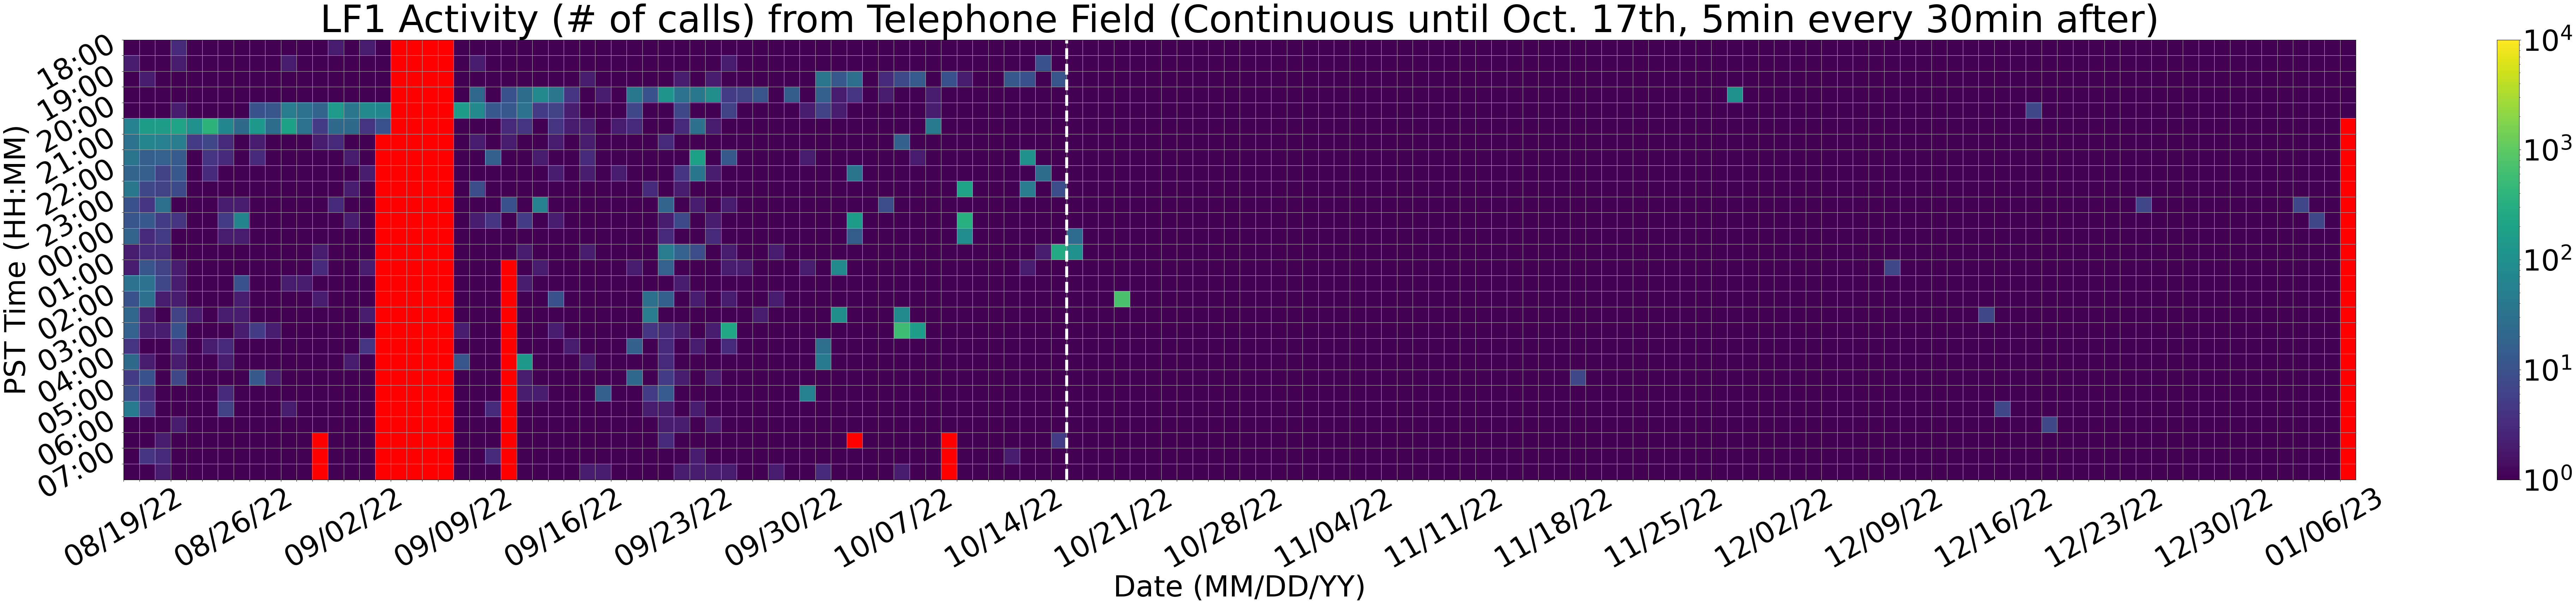

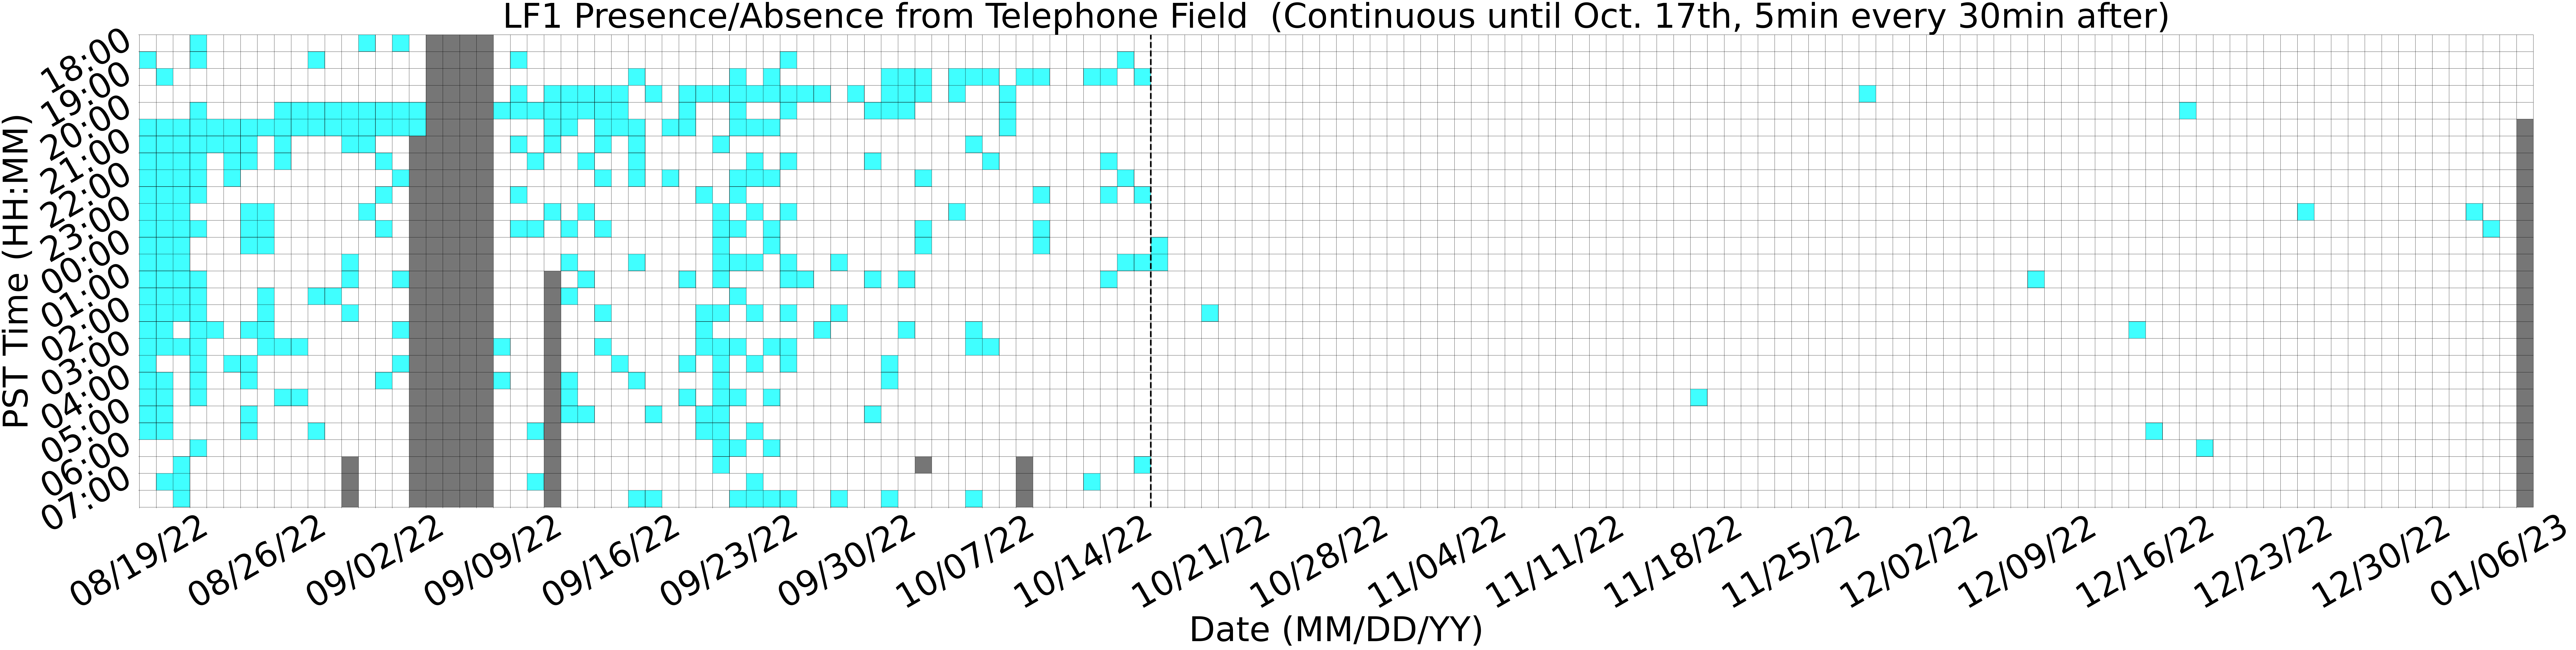

Telephone HF1


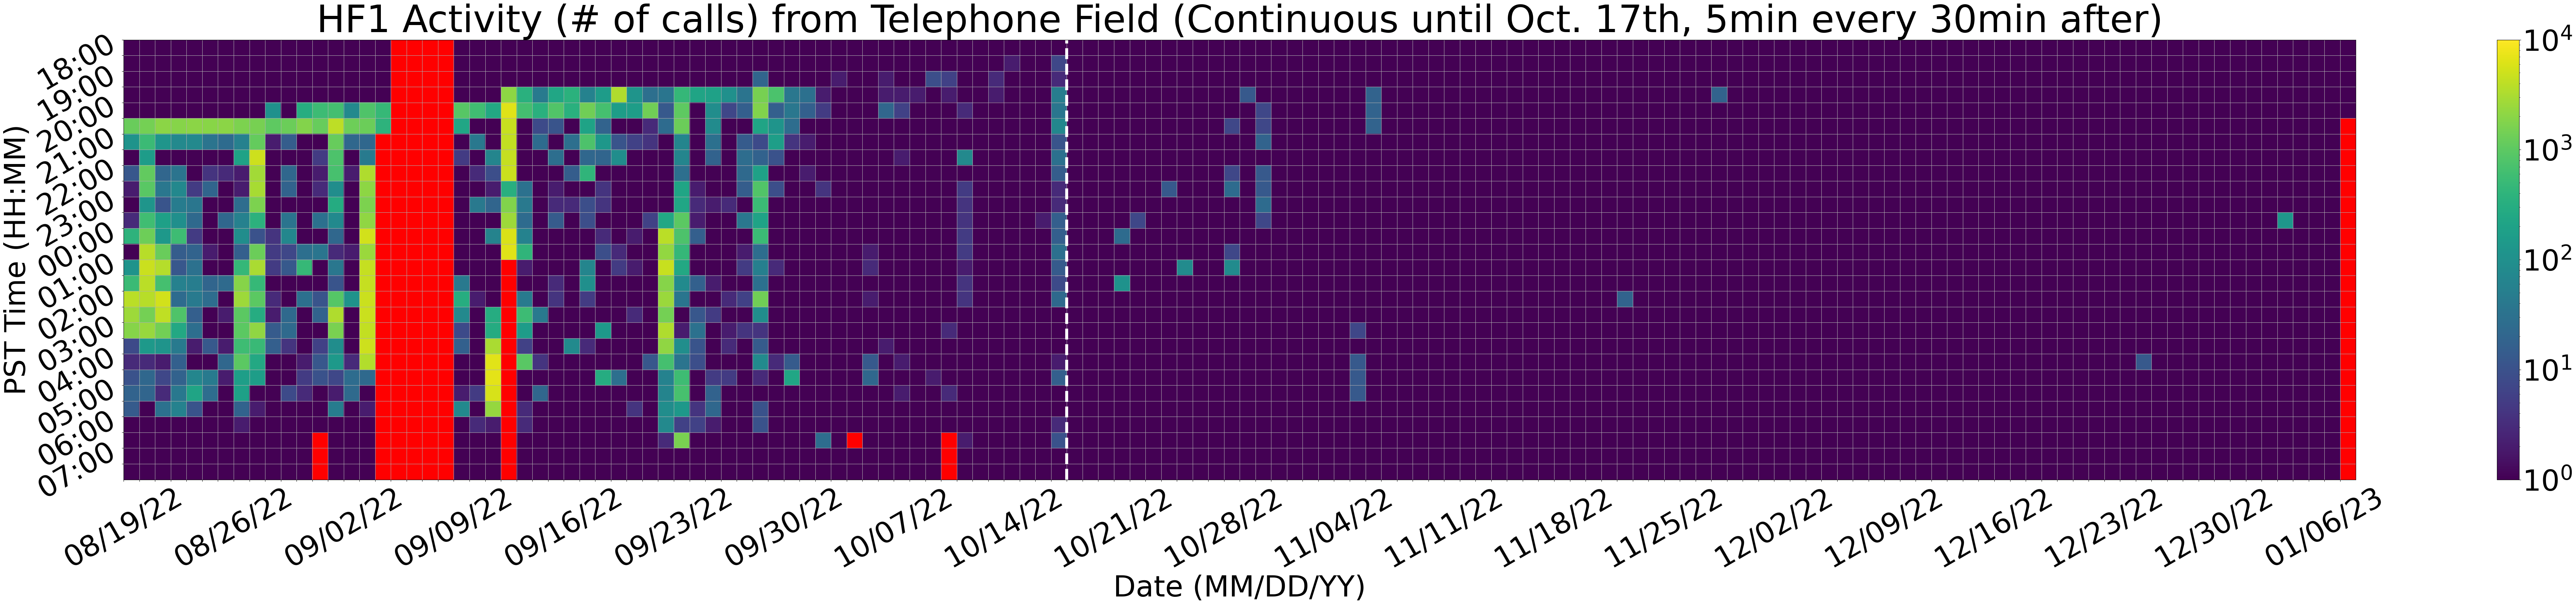

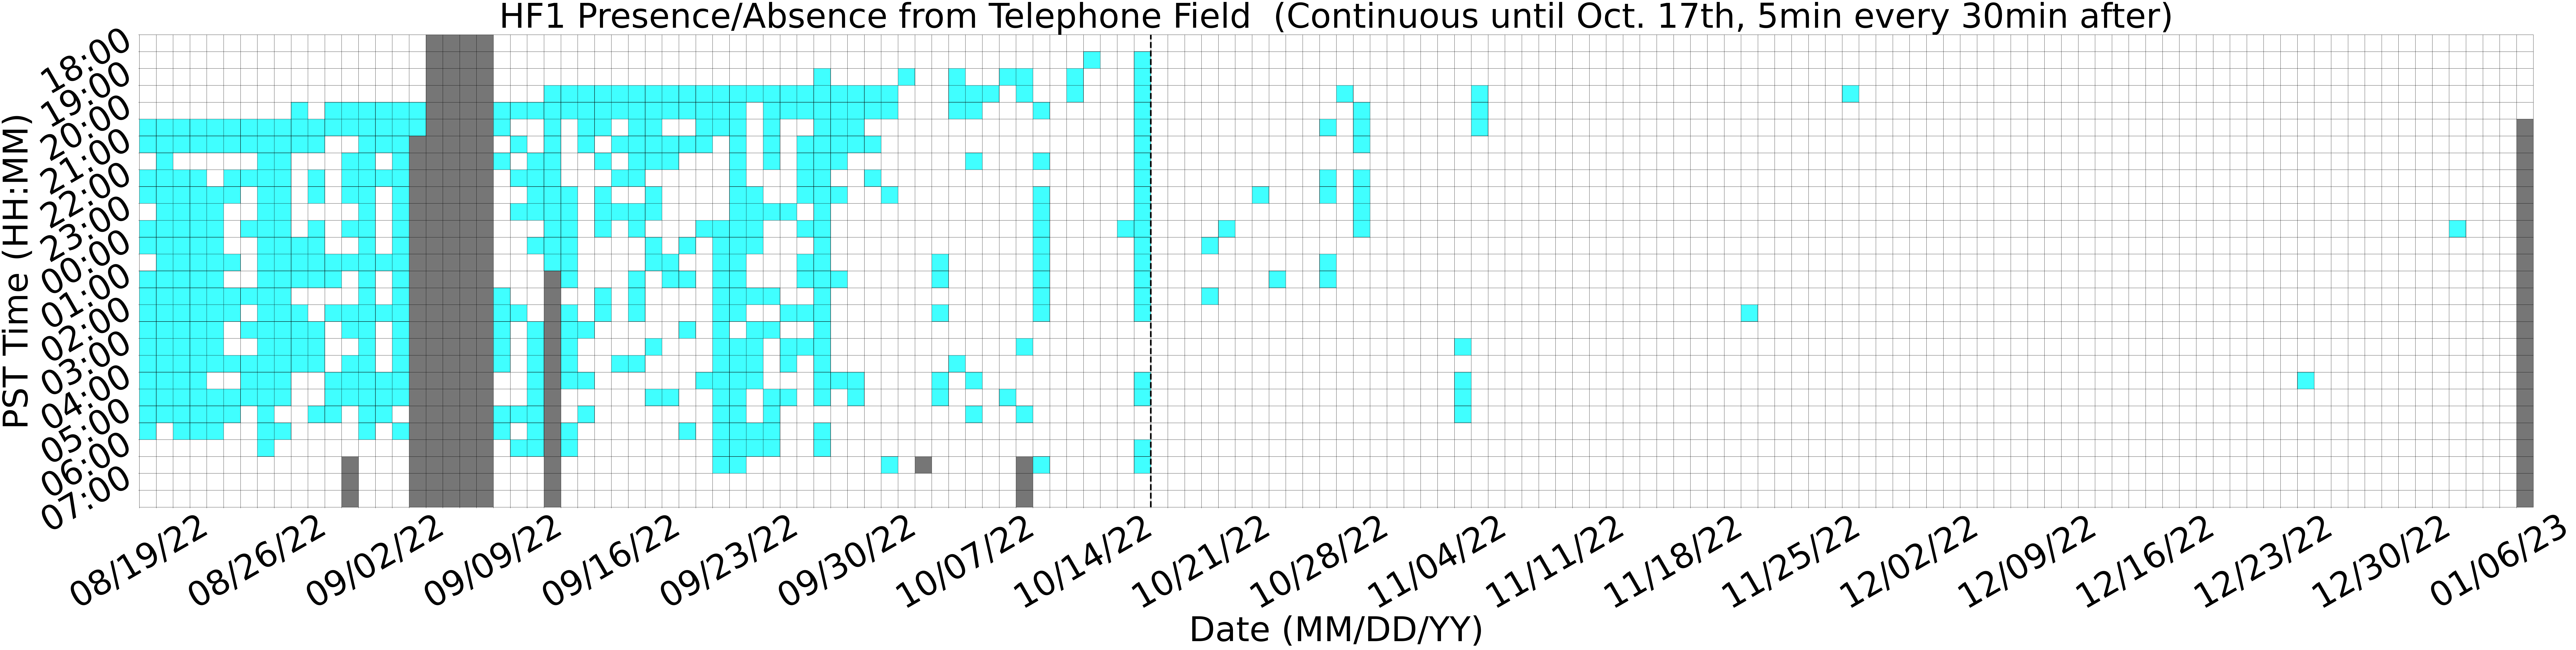

Telephone HF2


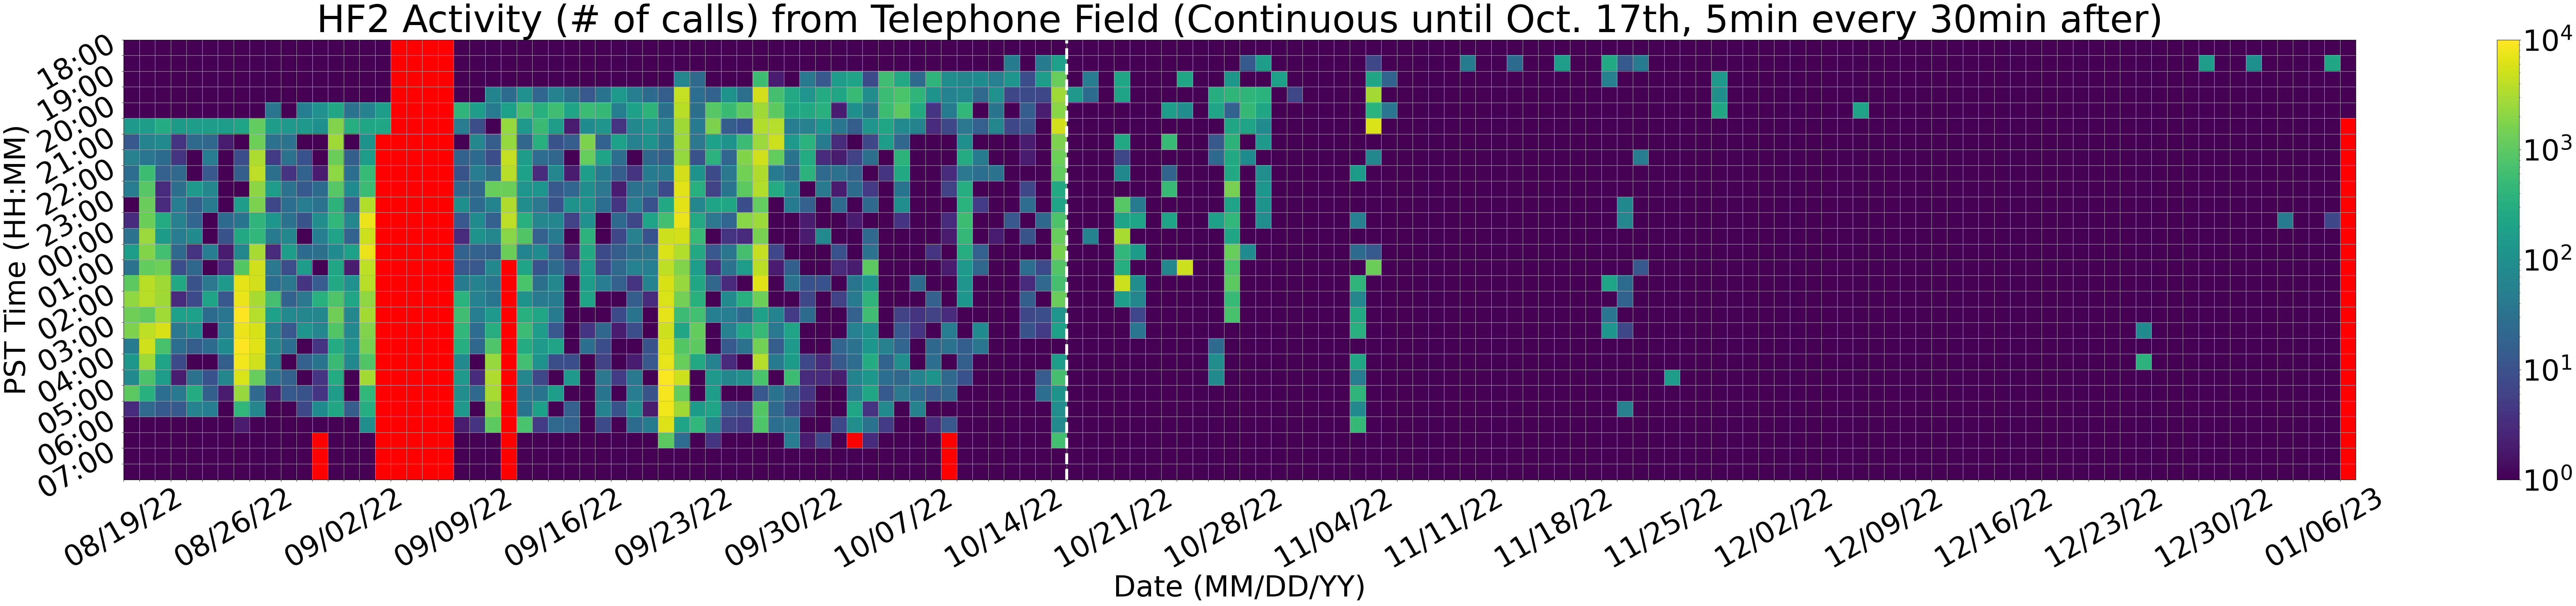

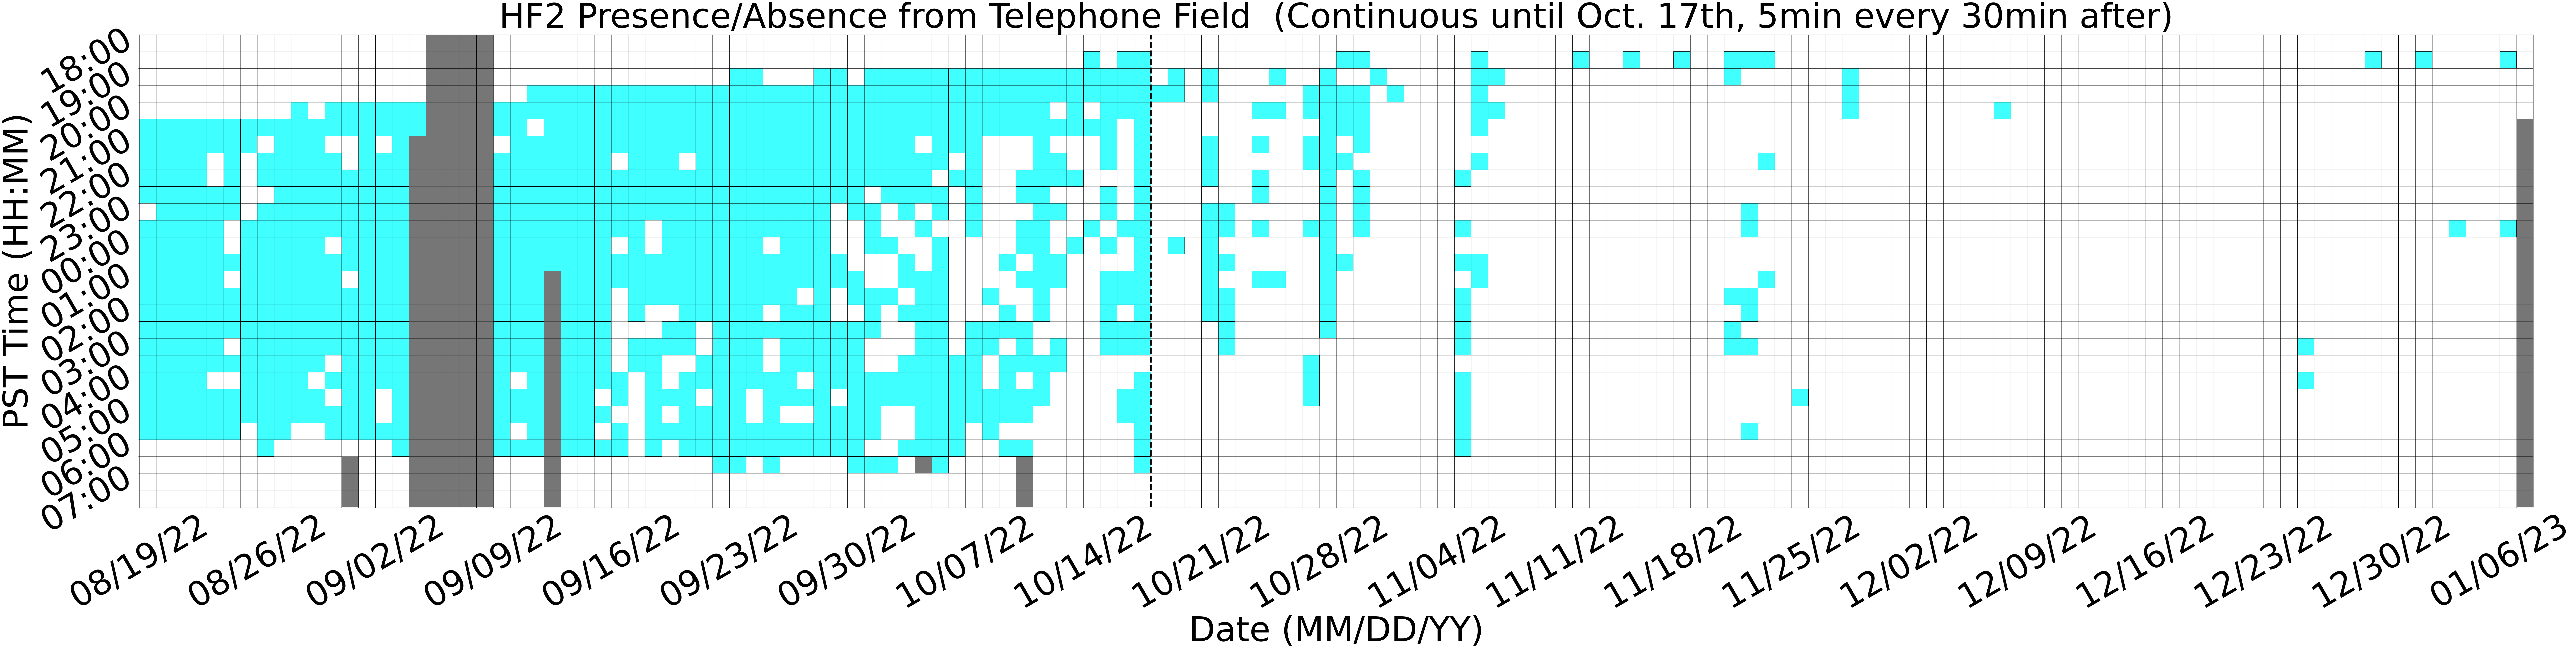

In [5]:
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['recording_start'] = '01:00'
data_params['recording_end'] = '15:00'

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = False
pipeline_params["save_presence_grid"] = False
pipeline_params["save_dc_night_comparisons"] = False
pipeline_params["save_activity_dc_comparisons"] = False
pipeline_params["save_presence_dc_comparisons"] = False
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = True

# for site_key in FREQ_GROUPS.keys():
site_key = 'Telephone'
for type_key in FREQ_GROUPS[site_key].keys():
    print(site_key, type_key)

    data_params["site_name"] = SITE_NAMES[site_key]
    data_params["site_tag"] = site_key
    data_params["type_tag"] = type_key

    file_paths = get_file_paths(data_params)

    location_df = assemble_initial_location_summary(data_params, file_paths) ## Use to update any bd2__(location summary).csv files
    activity_dets_arr = pd.DataFrame()

    dc_tag = data_params['cur_dc_tag']
    plottable_location_df = ss.simulate_dutycycle_on_detections(location_df.copy(), dc_tag)
    plottable_location_df.insert(0, 'call_durations', (plottable_location_df['call_end_time'] - plottable_location_df['call_start_time']))
    continuous_recording = plottable_location_df.loc[plottable_location_df['File Duration']!=300].copy()
    subsampled_recording = plottable_location_df.loc[plottable_location_df['File Duration']==300].copy()
    df_resampled_every_30_continuous = continuous_recording.resample(f"{data_params['resolution_in_min']}T", on='ref_time')
    df_resampled_every_30_subsampled = subsampled_recording.resample(f"{data_params['resolution_in_min']}T", on='ref_time')
    num_of_detections = pd.concat([df_resampled_every_30_continuous['ref_time'].count(), (1800//300)*df_resampled_every_30_subsampled['ref_time'].count()])

    all_processed_filepaths = sorted(list(map(str, list(Path(f'{file_paths["raw_SITE_folder"]}').glob('**/*.csv')))))
    all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)
    col_name = f"Number_of_Detections ({dc_tag})"
    incomplete_activity_arr = pd.DataFrame(num_of_detections.values, index=num_of_detections.index, columns=[col_name])
    activity_arr = incomplete_activity_arr.reindex(index=all_processed_datetimes, fill_value=0).resample(f"{data_params['resolution_in_min']}T").first()
    activity_arr = activity_arr.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    dc_dets = pd.DataFrame(list(zip(activity_arr.index, activity_arr[col_name].values)), columns=["Date_and_Time_UTC", col_name])
    dc_dets = dc_dets.set_index("Date_and_Time_UTC")
    activity_dets_arr = pd.concat([activity_dets_arr, dc_dets], axis=1)

    ss.test_subsampled_metrics_less_than_continuous(activity_dets_arr)

    plot_activity_grid_for_dets(activity_dets_arr, data_params, pipeline_params, file_paths)
    plot_presence_grid(activity_dets_arr, data_params, pipeline_params, file_paths)